# Project 3: Web APIs & NLP

## Import libraries

In [2]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import numpy as np
import re

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.svm import LinearSVC, SVC
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer


## Scrape Reddit's API

In [3]:
url = 'https://api.pushshift.io/reddit/search/submission'

In [3]:
# Got help from Nolan and Billy

#Build function that scrapes 5000 posts from a subreddit
def subreddit_scraper(subreddit):
    params = {
        'subreddit': subreddit,
        'size': 100,
    }
    
    res = requests.get(url, params)
    
    data = res.json()
    
    sub_posts = data['data']
    
    for i in range(49):
            utc = sub_posts[-1]['created_utc']
            params = {
                'subreddit': subreddit,
                'size': 100,
                'before': utc
            }
            data = requests.get(url, params)
            data = data.json()['data']
            sub_posts += data
            time.sleep(1)
    
    return sub_posts

In [270]:
%%time

hiphop_posts = subreddit_scraper('hiphopheads')

Wall time: 6min 22s


In [271]:
len(hiphop_posts)

5000

In [274]:
%%time

indie_posts = subreddit_scraper('indieheads')

Wall time: 6min 21s


In [275]:
len(indie_posts)

5000

## Create a dataframe from scraped posts

In [276]:
# Make a dataframe for r/hiphopheads posts
hiphop_df = pd.DataFrame(hiphop_posts)
# hiphop_df.head()

In [277]:
# Make a dataframe for r/indieheads posts
indie_df = pd.DataFrame(indie_posts)
# indie_df.head()

In [278]:
# Make columns
hiphop_df = hiphop_df[['subreddit', 'selftext', 'title']]
hiphop_df.head()

,subreddit,selftext,title
0,hiphopheads,,I got scammed badly....
1,hiphopheads,,[ORIGINAL] Just did my own EP and self-release...
2,hiphopheads,[removed],NuEminem is actually more skilled than the ori...
3,hiphopheads,,AAAC Wildlife Removal of Cincinnati &amp;#x2d;...
4,hiphopheads,[removed],"ASAP Mob Says ""Yams Day 2021"" Will Be Virtual"


In [279]:
hiphop_df.shape

(5000, 3)

In [280]:
# Make columns
indie_df = indie_df[['subreddit', 'selftext', 'title']]
indie_df.head()

,subreddit,selftext,title
0,indieheads,,"[FRESH] Sun Kil Moon - Welcome to Sparks, Nevada"
1,indieheads,,[FRESH ALBUM] Quantum Crossroads | The King's ...
2,indieheads,[deleted],[ORIGINAL] Timothy - Alone (Acoustic | Live in...
3,indieheads,,Joan Baez to Receive 2020 Kennedy Center Honor
4,indieheads,[deleted],[Speculation] New music on the way for Sufjan ...


In [281]:
indie_df.shape

(5000, 3)

In [282]:
# Concatenate both dataframes
df = pd.concat([hiphop_df, indie_df])

In [283]:
df.head()

,subreddit,selftext,title
0,hiphopheads,,I got scammed badly....
1,hiphopheads,,[ORIGINAL] Just did my own EP and self-release...
2,hiphopheads,[removed],NuEminem is actually more skilled than the ori...
3,hiphopheads,,AAAC Wildlife Removal of Cincinnati &amp;#x2d;...
4,hiphopheads,[removed],"ASAP Mob Says ""Yams Day 2021"" Will Be Virtual"


In [284]:
df.tail()

,subreddit,selftext,title
4995,indieheads,,Litti-XAVVY (Hip hop/Rap) 2020
4996,indieheads,,[ORIGINAL] Sara Wolff - You Like Talking About...
4997,indieheads,,[FRESH] Cemal Bilge Özşar - Yangın Geldiğinde;
4998,indieheads,,[FRESH] Lupin (Hippo Campus) - KO Kid (Live fr...
4999,indieheads,,"Ever listened to Turkish Indie Music? Well, ch..."


In [285]:
# Make a new column that binarizes the subreddits (hiphopheads = 1, indieheads = 0)

df['hiphop_or_indie'] = np.where(df['subreddit'] == 'hiphopheads', 1, 0)

In [286]:
df.head()

,subreddit,selftext,title,hiphop_or_indie
0,hiphopheads,,I got scammed badly....,1
1,hiphopheads,,[ORIGINAL] Just did my own EP and self-release...,1
2,hiphopheads,[removed],NuEminem is actually more skilled than the ori...,1
3,hiphopheads,,AAAC Wildlife Removal of Cincinnati &amp;#x2d;...,1
4,hiphopheads,[removed],"ASAP Mob Says ""Yams Day 2021"" Will Be Virtual",1


In [287]:
# Combine selftext and title with a space between them
df['selftext_&_title'] = df['selftext'] + ' ' + df['title']

In [288]:
df.head()

,subreddit,selftext,title,hiphop_or_indie,selftext_&_title
0,hiphopheads,,I got scammed badly....,1,I got scammed badly....
1,hiphopheads,,[ORIGINAL] Just did my own EP and self-release...,1,[ORIGINAL] Just did my own EP and self-releas...
2,hiphopheads,[removed],NuEminem is actually more skilled than the ori...,1,[removed] NuEminem is actually more skilled th...
3,hiphopheads,,AAAC Wildlife Removal of Cincinnati &amp;#x2d;...,1,AAAC Wildlife Removal of Cincinnati &amp;#x2d...
4,hiphopheads,[removed],"ASAP Mob Says ""Yams Day 2021"" Will Be Virtual",1,"[removed] ASAP Mob Says ""Yams Day 2021"" Will B..."


In [289]:
# Count null values
df.isnull().sum()

subreddit            0
selftext            16
title                0
hiphop_or_indie      0
selftext_&_title    16
dtype: int64

In [290]:
# Drop null values

df.dropna(inplace=True)
df.isnull().sum()

subreddit           0
selftext            0
title               0
hiphop_or_indie     0
selftext_&_title    0
dtype: int64

In [291]:
df.head()

,subreddit,selftext,title,hiphop_or_indie,selftext_&_title
0,hiphopheads,,I got scammed badly....,1,I got scammed badly....
1,hiphopheads,,[ORIGINAL] Just did my own EP and self-release...,1,[ORIGINAL] Just did my own EP and self-releas...
2,hiphopheads,[removed],NuEminem is actually more skilled than the ori...,1,[removed] NuEminem is actually more skilled th...
3,hiphopheads,,AAAC Wildlife Removal of Cincinnati &amp;#x2d;...,1,AAAC Wildlife Removal of Cincinnati &amp;#x2d...
4,hiphopheads,[removed],"ASAP Mob Says ""Yams Day 2021"" Will Be Virtual",1,"[removed] ASAP Mob Says ""Yams Day 2021"" Will B..."


In [292]:
# Indices appear twice because dataframes were concatenated, so index was reset
# Referred to this page: https://www.geeksforgeeks.org/python-pandas-dataframe-reset_index/

df.reset_index(inplace=True)

In [293]:
df.shape

(9984, 6)

In [294]:
df.dtypes

index                int64
subreddit           object
selftext            object
title               object
hiphop_or_indie      int32
selftext_&_title    object
dtype: object

In [295]:
# Save dataframe in a csv file

df.to_csv('./data/df.csv')

In [4]:
# Read in csv
df = pd.read_csv('./data/df.csv')

In [5]:
# Drop unnecessary columns
df.drop(['Unnamed: 0', 'index'], axis=1, inplace=True)
df

,subreddit,selftext,title,hiphop_or_indie,selftext_&_title
0,hiphopheads,NaN,I got scammed badly....,1,I got scammed badly....
1,hiphopheads,NaN,[ORIGINAL] Just did my own EP and self-release...,1,[ORIGINAL] Just did my own EP and self-releas...
2,hiphopheads,[removed],NuEminem is actually more skilled than the ori...,1,[removed] NuEminem is actually more skilled th...
3,hiphopheads,NaN,AAAC Wildlife Removal of Cincinnati &amp;#x2d;...,1,AAAC Wildlife Removal of Cincinnati &amp;#x2d...
4,hiphopheads,[removed],"ASAP Mob Says ""Yams Day 2021"" Will Be Virtual",1,"[removed] ASAP Mob Says ""Yams Day 2021"" Will B..."
...,...,...,...,...,...
9979,indieheads,NaN,Litti-XAVVY (Hip hop/Rap) 2020,0,Litti-XAVVY (Hip hop/Rap) 2020
9980,indieheads,NaN,[ORIGINAL] Sara Wolff - You Like Talking About...,0,[ORIGINAL] Sara Wolff - You Like Talking Abou...
9981,indieheads,NaN,[FRESH] Cemal Bilge Özşar - Yangın Geldiğinde;,0,[FRESH] Cemal Bilge Özşar - Yangın Geldiğinde;
9982,indieheads,NaN,[FRESH] Lupin (Hippo Campus) - KO Kid (Live fr...,0,[FRESH] Lupin (Hippo Campus) - KO Kid (Live f...


## Create Tokenizer And Lemmatizier

In [6]:
# Instantiate tokenzier that splits tokens up by spaces or by periods that are not attached to a digit
# Referred to lesson 5.03

tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

In [7]:
# Instantiate lemmatizer.

lemmatizer = WordNetLemmatizer()

In [8]:
df.columns

Index(['subreddit', 'selftext', 'title', 'hiphop_or_indie',
       'selftext_&_title'],
      dtype='object')

In [9]:
# Build for loop that tokenizes, lemmatizes, and cleans the data
# Referred to this page: https://stackoverflow.com/questions/1276764/stripping-everything-but-alphanumeric-chars-from-a-string-in-python

df['self_title_tok_lem'] = ''

for i in range(len(df['selftext_&_title'])):
    
    # Remove URLs
    # Referred to this page: https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python/11332580
    no_url = []
    no_url.append(re.sub(r'http\S+', '', df['selftext_&_title'][i]))
    
    # Tokenize the 'selftext_&_title' column
    tok = []
    token_self_title = tokenizer.tokenize(no_url[0])
    tok.extend(token_self_title) # Extend is used instead of append because it adds elements from the iterable
    
    # Drop duplicate tokens
    tok_list = []
    [tok_list.append(x) for x in tok if x not in tok_list]
    
    # Lemmatize
    tokens_lem = [lemmatizer.lemmatize(t) for t in tok_list]
    
    # Remove non alphanumeric characters
    only_alphanum = []
    for a in range(len(tokens_lem)):
        only_alphanum.append(re.sub(r'\W+', '', tokens_lem[a]))
    
    only_alphanum = ' '.join(only_alphanum)
    
    # Referred to this page: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
    df.loc[i, 'self_title_tok_lem'] = only_alphanum
    
    

In [10]:
df

,subreddit,selftext,title,hiphop_or_indie,selftext_&_title,self_title_tok_lem
0,hiphopheads,NaN,I got scammed badly....,1,I got scammed badly....,I got scammed badly
1,hiphopheads,NaN,[ORIGINAL] Just did my own EP and self-release...,1,[ORIGINAL] Just did my own EP and self-releas...,ORIGINAL Just did my own EP and self released ...
2,hiphopheads,[removed],NuEminem is actually more skilled than the ori...,1,[removed] NuEminem is actually more skilled th...,removed NuEminem is actually more skilled than...
3,hiphopheads,NaN,AAAC Wildlife Removal of Cincinnati &amp;#x2d;...,1,AAAC Wildlife Removal of Cincinnati &amp;#x2d...,AAAC Wildlife Removal of Cincinnati ampx2d Tra...
4,hiphopheads,[removed],"ASAP Mob Says ""Yams Day 2021"" Will Be Virtual",1,"[removed] ASAP Mob Says ""Yams Day 2021"" Will B...",removed ASAP Mob Says Yams Day 2021 Will Be V...
...,...,...,...,...,...,...
9979,indieheads,NaN,Litti-XAVVY (Hip hop/Rap) 2020,0,Litti-XAVVY (Hip hop/Rap) 2020,Litti XAVVY Hip hop Rap 2020
9980,indieheads,NaN,[ORIGINAL] Sara Wolff - You Like Talking About...,0,[ORIGINAL] Sara Wolff - You Like Talking Abou...,ORIGINAL Sara Wolff You Like Talking About Yo...
9981,indieheads,NaN,[FRESH] Cemal Bilge Özşar - Yangın Geldiğinde;,0,[FRESH] Cemal Bilge Özşar - Yangın Geldiğinde;,FRESH Cemal Bilge Özşar Yangın Geldiğinde
9982,indieheads,NaN,[FRESH] Lupin (Hippo Campus) - KO Kid (Live fr...,0,[FRESH] Lupin (Hippo Campus) - KO Kid (Live f...,FRESH Lupin Hippo Campus KO Kid Live from th...


In [13]:
# Look at the datatypes for each column
df.dtypes

subreddit             object
selftext              object
title                 object
hiphop_or_indie        int64
selftext_&_title      object
self_title_tok_lem    object
dtype: object

In [19]:
# Use CountVectorizer to find the most common 2-word phrases (bigrams)
cvec = CountVectorizer(ngram_range=(2, 2)) # Only plotting for bigrams because plotting for trigrams returns a MemoryError
cvec.fit(df['selftext_&_title'])
cvec_self_title = cvec.transform(df['selftext_&_title'])

before_tok_lem = pd.DataFrame(cvec_self_title.todense(), 
                          columns=cvec.get_feature_names())

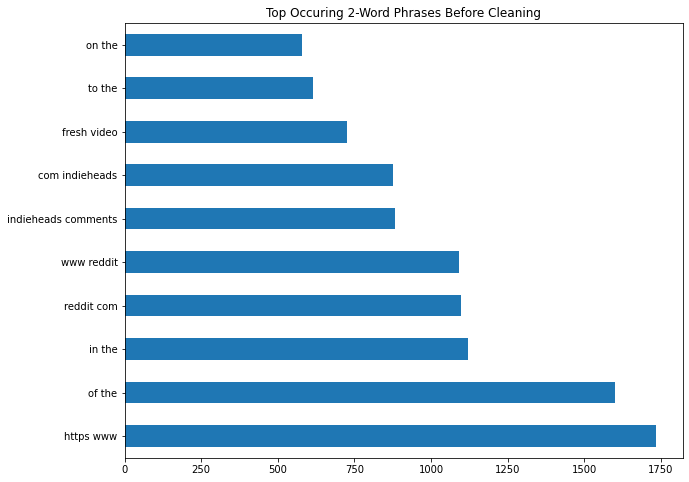

In [20]:
# Plot bigrams
plt.figure(figsize=(10, 8))
before_tok_lem.sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('Top Occuring 2-Word Phrases Before Cleaning', fontsize=12);

In [21]:
# Repeat the previous cells, but with the tokenized/lemmatized column
cvec = CountVectorizer(ngram_range=(2, 2)) # Only plotting for bigrams because plotting for trigrams returns a MemoryError
cvec.fit(df['self_title_tok_lem'])
cvec_self_title = cvec.transform(df['self_title_tok_lem'])

after_tok_lem = pd.DataFrame(cvec_self_title.todense(), 
                          columns=cvec.get_feature_names())

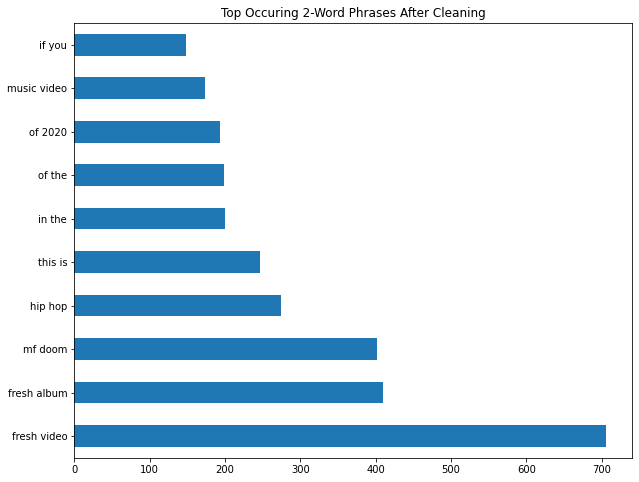

In [22]:
# Plot bigrams
plt.figure(figsize=(10, 8))
after_tok_lem.sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('Top Occuring 2-Word Phrases After Cleaning', fontsize=12);

As shown in the two bar charts above, the top occuring 2-word phrases change after the reddit posts were cleaned, tokenized, and lemmatized. This discards meaningless occurances (such as URLs) and phrases that tend to appear a lot in both r/HipHopHeads and r/Indieheads.

## Stopwords

Since the phrases shown in the post-cleaning bar chart frequently appear in both subreddits, they will be added to stopwords.

In [24]:
# No ngrams specified because a MemoryError kept occuring
cvec = CountVectorizer(stop_words=['if', 'you', 'music', 'video', 'of', '2020', 'the',
                                                       'in', 'this', 'is', 'hip', 'hop', 'mf', 'doom',
                                                       'fresh', 'album'])

cvec.fit(df['self_title_tok_lem'])
cvec_self_title = cvec.transform(df['self_title_tok_lem'])

stopwords_removed = pd.DataFrame(cvec_self_title.todense(), 
                          columns=cvec.get_feature_names())

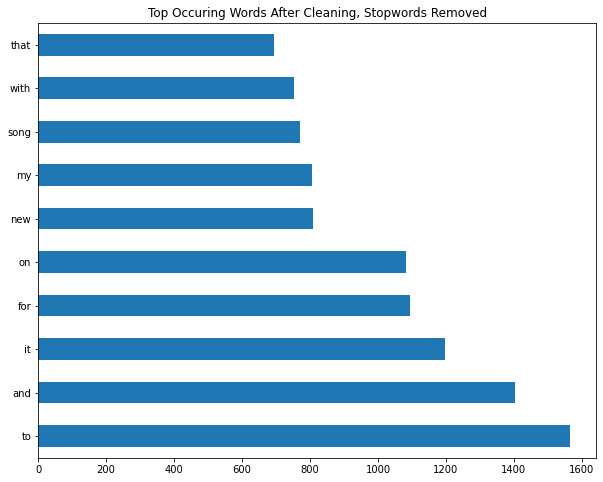

In [26]:
# Plot most common words
plt.figure(figsize=(10, 8))
stopwords_removed.sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('Top Occuring Words After Cleaning, Stopwords Removed', fontsize=12);

The bar chart above shows the top occuring words after cleanining and removing the specified stopwords.

## Variable Selection

In [14]:
# Referred to lesson 5.04
# Assign X and y variables to columns
X = df['self_title_tok_lem']
y = df['hiphop_or_indie'] # target

In [15]:
# baseline
y.value_counts(normalize=True)

0    0.5002
1    0.4998
Name: hiphop_or_indie, dtype: float64

In [16]:
1 - y.mean()

0.5002003205128205

In [17]:
# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [18]:
y_test.value_counts(normalize=True)

0    0.500152
1    0.499848
Name: hiphop_or_indie, dtype: float64

## Modeling

### Multinomial Naive Bayes with CountVectorizer

In [32]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=['if', 'you', 'music', 'video', 'of', '2020', 'the',
                                                       'in', 'this', 'is', 'hip', 'hop', 'mf', 'doom',
                                                       'fresh', 'album'])),
    ('nb', MultinomialNB())
])

In [33]:
# Estimate how the model will perform on unseen data
cross_val_score(pipe, X_train, y_train, cv=3).mean()

0.8144735015601517

In [34]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(stop_words=['if', 'you', 'music', 'video',
                                             'of', '2020', 'the', 'in', 'this',
                                             'is', 'hip', 'hop', 'mf', 'doom',
                                             'fresh', 'album'])),
                ('nb', MultinomialNB())])

In [35]:
pipe.score(X_train, y_train)

0.9280908955000747

In [38]:
pipe.score(X_test, y_test)

0.8336874051593324

In [39]:
# Referred to CountVectorizer documentation: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# Set up parameters of pipeline
pipe_params = {
    'cvec__max_features' : [100, 500, 800, 1000],
    'cvec__min_df' : [2, 3],
    'cvec__max_df' : [.90, .95],
    'cvec__ngram_range' : [(1,1) , (1,2)],
    'cvec__stop_words': ['english', None]
}

In [40]:
# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5)

In [41]:
%%time
# Fit the model
gs.fit(X_train, y_train)

Wall time: 1min


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['if', 'you',
                                                                    'music',
                                                                    'video',
                                                                    'of',
                                                                    '2020',
                                                                    'the', 'in',
                                                                    'this',
                                                                    'is', 'hip',
                                                                    'hop', 'mf',
                                                                    'doom',
                                                                    'fresh',
                                                                    'album']

In [42]:
gs.best_score_

0.786963652645807

In [49]:
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 1000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None}

The best performing parameters are shown above.

In [50]:
gs.score(X_train, y_train)

0.8078935565854388

In [51]:
gs.score(X_test, y_test)

0.8006069802731411

The training and testing score are extremely close to each, which indicates that the model works well with new data.

In [52]:
# Get predictions
pred = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

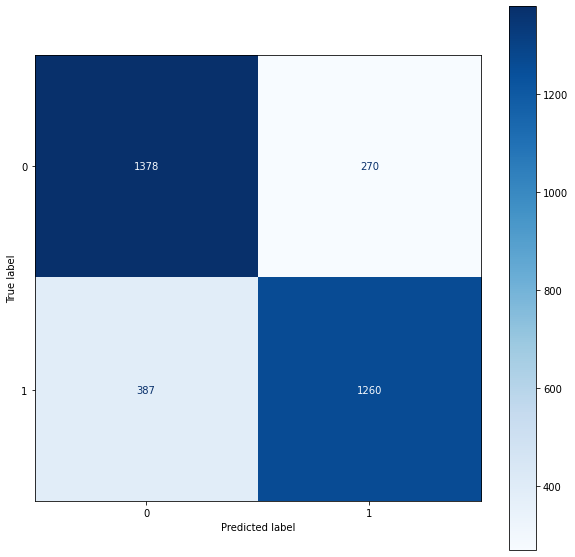

In [67]:
# View confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d', ax=ax);

A confusion matrix is a convenient way to visualize how our model performs. It describes the peformance of a classification model on a dataset for which the true and predicted values are known.

In [54]:
# Calculate the specificity
spec = tn / (tn + fp)

spec

0.8361650485436893

Specificity is the true negative rate. In other words, it's the proportion of correctly defined negative values. This is important because maximizing for specificty also means minimizing false positives.

### Logistic Regression with CountVectorizer

In [29]:
%%time

# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Logistic Regression (estimator)
pipe_cv = Pipeline([
    ('cvec', CountVectorizer(stop_words=['if', 'you', 'music', 'video', 'of', '2020', 'the',
                                                       'in', 'this', 'is', 'hip', 'hop', 'mf', 'doom',
                                                       'fresh', 'album'])),
    ('lr', LogisticRegression(solver = 'liblinear')) # liblinear was used because the coef_ would not converge when using sag or saga, no matter how many times the max_iter was changed
])

# Define grid of parameters to GridSearch over.
params_grid = {
    'cvec__max_features': [100, 500, 800, 1000],
    'cvec__stop_words': ['english', None],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__min_df' : [2, 3],
    'cvec__max_df' : [0.7, 0.8, 0.9, .95],
    'lr__max_iter' : [1000, 2000, 5000]
}

# GridSearch over pipeline with given grid of parameters.
gs_cv = GridSearchCV(pipe_cv, params_grid, cv=5)

# Fit model.
gs_cv.fit(X_train, y_train)

Wall time: 7min 38s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['if', 'you',
                                                                    'music',
                                                                    'video',
                                                                    'of',
                                                                    '2020',
                                                                    'the', 'in',
                                                                    'this',
                                                                    'is', 'hip',
                                                                    'hop', 'mf',
                                                                    'doom',
                                                                    'fresh',
                                                                    'album']

In [30]:
gs_cv.best_score_

0.8250547378691518

In [31]:
gs_cv.best_params_

{'cvec__max_df': 0.7,
 'cvec__max_features': 1000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english',
 'lr__max_iter': 1000}

In [32]:
gs_cv.score(X_train, y_train)

0.8624465811965812

In [34]:
gs_cv.score(X_test, y_test)

0.8173076923076923

Both the training and testing score in this case are higher than the previous scores. However, there is some distance between them, so this model is a little overfit.

In [35]:
# Get predictions
pred = gs_cv.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
pred

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

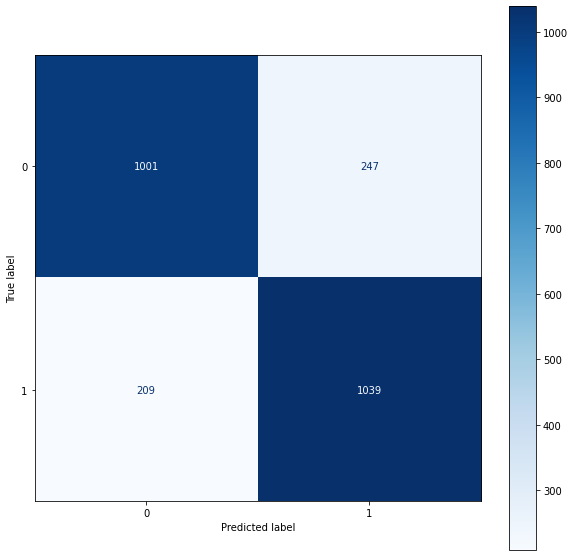

In [36]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(gs_cv, X_test, y_test, cmap='Blues', values_format='d', ax=ax);

In [37]:
# Calculate the specificity
spec = tn / (tn + fp)

spec

0.8020833333333334

### Multinomial Naive Bayes with TFIDFVectorizer

In [69]:
# Let's set a pipeline up with two stages:
# 1. TfidfVectorizer (transformer)
# 2. MultinomialNB (estimator)
tvec_pipe = Pipeline([
    ('tvec' , TfidfVectorizer(stop_words=['if', 'you', 'music', 'video', 'of', '2020', 'the',
                                                       'in', 'this', 'is', 'hip', 'hop', 'mf', 'doom',
                                                       'fresh', 'album'])),
    ('nb' , MultinomialNB()) # Estimator fit failed with GaussianNB so multinomial was used
])

In [70]:
# Set up parameters
pipe_params_tvec = {
    'tvec__max_features' : [100, 500, 800, 1000],
    'tvec__stop_words' : [None, 'english'],
    'tvec__ngram_range' : [(1,1), (1,2)],
    'tvec__min_df' : [2, 3],
    'tvec__max_df' : [.90, .95]
}

In [71]:
# Instantiate GridSearchCV.
gs_tvec = GridSearchCV(tvec_pipe,
                      pipe_params_tvec,
                      cv = 5,
                      verbose=1)

In [72]:
%%time
# Fit model
gs_tfidf = gs_tvec.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:   59.9s finished


Wall time: 1min


In [73]:
gs_tfidf.score(X_train, y_train)

0.8102855434295111

In [74]:
gs_tfidf.score(X_test, y_test)

0.7969650986342944

Although this model isn't very overfit, its testing score is lower than the scores of the previous models.

In [80]:
# Get predictions
preds = gs_tvec.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()


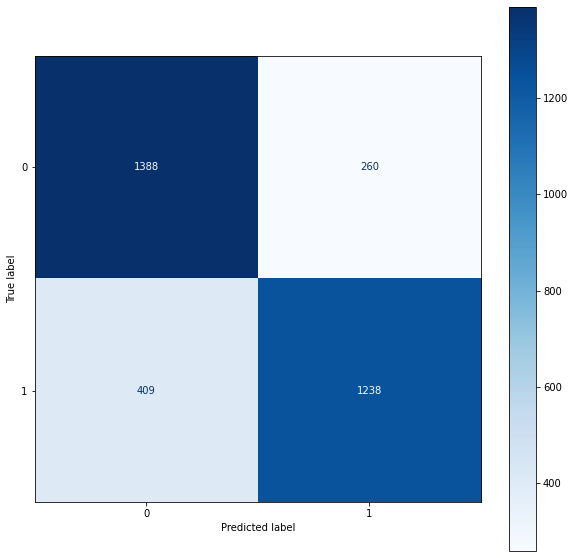

In [81]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(gs_tvec, X_test, y_test, cmap='Blues', values_format='d', ax=ax);

In [82]:
# Calculate the specificity
spec_tvec = tn / (tn + fp)

spec_tvec

0.8422330097087378

### Random Forest Classifier with CountVectorizer

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=35, stratify=y)

In [20]:
rf = RandomForestClassifier()

In [21]:
model_params = {}
count = 0

In [25]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. RandomForestClassifier (estimator)
pipe_rf = Pipeline([
    ('cv', CountVectorizer(stop_words=['if', 'you', 'music', 'video', 'of', '2020', 'the',
                                                       'in', 'this', 'is', 'hip', 'hop', 'mf', 'doom',
                                                       'fresh', 'album'])),
    ('rf', RandomForestClassifier(random_state=33, n_jobs=6))
])

# Set up parameters
params = {
    'rf__n_estimators' : [50, 75, 100, 150],
    #'rf__max_features' : [None, 'auto', 'log2'],
    'rf__max_depth' : [None, 3, 4, 5, 6],
    'rf__ccp_alpha' : [0, 0.0001, 0.01, 0.1]
#     'n_estimators': [100, 150, 200],
#     'max_depth': [None, 1, 2, 3, 4, 5]
}

gs = GridSearchCV(pipe_rf, param_grid=params, cv=5)

# Fit model
gs.fit(X_train, y_train)

count += 1

gs.best_params_['score'] = gs.best_score_
model_params[f"model_{count}"] = gs.best_params_

model_df = pd.DataFrame.from_dict(model_params, orient='index')
model_df

,rf__ccp_alpha,rf__max_depth,rf__n_estimators,score
model_1,0,None,75,0.79621
model_2,0,None,75,0.79621


In [26]:
gs.score(X_train, y_train)

0.9949252136752137

In [27]:
gs.score(X_test, y_test)

0.8052884615384616

This model is very overfit, as shown by the difference between the training and testing score.

In [40]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()


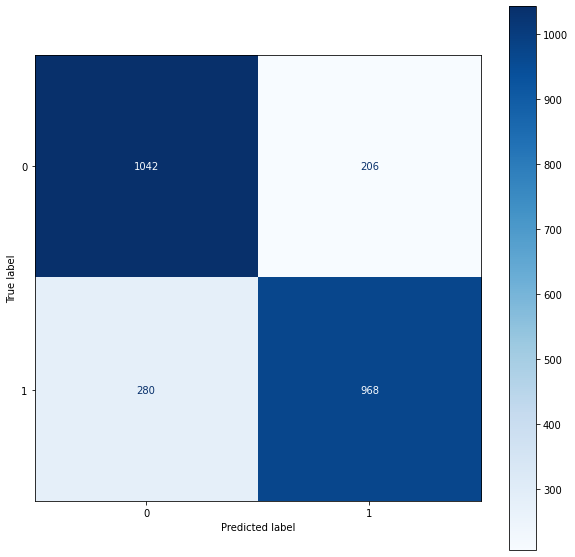

In [39]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d', ax=ax);

In [41]:
# Calculate the specificity
spec = tn / (tn + fp)

spec

0.8349358974358975

## Conclusion

The Logistic Regression with a CountVectorizer performed the best and should be used when predicting the origin of a post. Although the model is slightly overfit, it scored well in comparison to the other models that were tested. Also, the specificity isn't the highest of all the models, but it isn't much lower than the rest and it's still considerably high. The writers at The Fader would find their research process to be less time-consuming once they implement this model.

## Recommendations

- Experiment with more parameters when testing this model to see if they increase/decrease the scores
- Add more stopwords to see if this improves the accuracy
- Test model on less popular subreddits to see if the model performs as well and adjust accordingly if it doesn't
- Preprocessing and modeling with a more powerful computer would produce results much sooner and reduce crashes and MemoryErrors
- Explore other methods such as boosting